# Прикладные задачи анализа данных

## Домашнее задание 4

В этой работе мы будем решать задачу рекомендаций музыки. Для этого мы реализуем метод коллаборативной фильтрации и модель со скрытыми переменными, сравним их между собой и попытаемся сделать выводы. Во всех заданиях разрешается переписывать код по своему усмотрению, предложенные шаблоны несут лишь рекомендательный характер.

In [1]:
from sklearn.preprocessing import LabelEncoder

import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from typing import Callable, List

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as scs

In [2]:
ratings = pd.read_csv('music_dataset.csv')
ratings.head()

,userId,trackId
0,0,14
1,0,95
2,0,219
3,0,220
4,0,404


In [3]:
tracks_info = pd.read_csv('tracks_info.csv')
tracks_info.head()

,id,name,artists
0,0,What There Is,['a-ha']
1,1,I'll Play The Blues For You,['Albert King']
2,2,Breaking Up Somebody's Home,['Albert King']
3,3,Imma Be,['Black Eyed Peas']
4,4,Boom Boom Pow,['Black Eyed Peas']


Для оценки качества рекомендаций мы будем использовать метрику $MAP@k$.

$$
MAP@k = \frac{1}{N} \sum_{u = 1}^N AP_u@k
$$
$$
AP_u@k = \frac{1}{\min(k, n_u)} \sum_{i=1}^k r_u(i) p_u@i
$$
$$p_u@k = \dfrac{1}{k}\sum_{j=1}^k r_u(j)$$


*   $N$ - количество пользователей.
*   $n_u$ - число релевантных треков пользователя $u$ на тестовом промежутке.
*   $r_u(i)$ - бинарная величина: относится ли трек на позиции $i$ к релевантным.

**Задание 1 (1 балл).** Реализуйте метрику $MAP@k$.

In [4]:
def mapk(relevant: List[List[int]], predicted: List[List[int]], k: int = 20):
  sum_avg_precision = 0
  for user_relevant, user_predicted in zip(relevant, predicted):
      user_avg_precision = 0
      hits = 0
      for i, item in enumerate(user_predicted[:k]):
          if item in user_relevant:
              hits += 1
              user_avg_precision += hits / (i + 1)
      sum_avg_precision += user_avg_precision / min(len(user_relevant), k)
  return sum_avg_precision / len(relevant)

In [5]:
relevant = [
    [1, 7, 6, 2, 8],
    [1, 5, 4, 8],
    [8, 2, 5]
]

pred = [
    [8, 1, 5, 0, 7, 2, 9, 4],
    [0, 1, 8, 5, 3, 4, 7, 9],
    [9, 2, 0, 6, 8, 5, 3, 7]
]

assert round(mapk(relevant, pred, k=5), 4) == 0.4331

Разделим данные на тренировочные и тестовые так, чтобы в теcтовый датасет попали 50 последних треков каждого пользователя.

In [6]:
def train_test_split(ratings):
    train_ratings, test_ratings = [], []
    num_test_samples = 50

    # getting train samples
    for userId, user_data in tqdm(ratings.groupby('userId')):
        train_ratings += [user_data[:-num_test_samples]]

    train_ratings = pd.concat(train_ratings).reset_index(drop=True)
    all_train_items = train_ratings['trackId'].unique()

    # getting train samples
    # we drop all tracks that are not presented it the training samples,
    # because we won't be able to learn representations for them
    for userId, user_data in tqdm(ratings.groupby('userId')):
        test_items = user_data[-num_test_samples:]
        test_items = test_items[np.isin(test_items['trackId'], all_train_items)]
        test_ratings += [test_items]

    test_ratings = pd.concat(test_ratings).reset_index(drop=True)

    return train_ratings, test_ratings

In [7]:
train_ratings, test_ratings = train_test_split(ratings)

  0%|          | 0/241 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

Почистим табличку с информацией о треках и закодируем id треков так, чтобы они соответствовали их порядковому номеру.

In [8]:
redundant_rows = np.where(~np.isin(tracks_info['id'], train_ratings['trackId'].unique()))[0]
tracks_info.drop(redundant_rows, inplace=True)
tracks_info = tracks_info.reset_index(drop=True)

In [9]:
def ids_encoder(ratings):
    users = sorted(ratings['userId'].unique())
    items = sorted(ratings['trackId'].unique())

    # create users and items encoders
    uencoder = LabelEncoder()
    iencoder = LabelEncoder()

    # fit users and items ids to the corresponding encoder
    uencoder.fit(users)
    iencoder.fit(items)

    return uencoder, iencoder

In [10]:
uencoder, iencoder = ids_encoder(train_ratings)
train_ratings['trackId'] = iencoder.transform(train_ratings['trackId'].tolist())
test_ratings['trackId'] = iencoder.transform(test_ratings['trackId'].tolist())
tracks_info['id'] = iencoder.transform(tracks_info['id'].tolist())

In [11]:
train_ratings.head()

,userId,trackId
0,0,14
1,0,95
2,0,219
3,0,220
4,0,404


In [12]:
test_ratings.head()

,userId,trackId
0,0,57582
1,0,57802
2,0,57957
3,0,58174
4,0,59168


Соберем все релевантные треки для каждого пользователя в список.

In [13]:
test_relevant = []
test_users = []
for user_id, user_data in test_ratings.groupby('userId'):
    test_relevant += [user_data['trackId'].tolist()]
    test_users.append(user_id)

**Задание 2 (1 балл).** Реализуйте метод `get_test_recommendations` в классе `BaseModel`. Он принимает на вход параметр `k` и возвращает массив из `k` наиболее подходящих треков для каждого пользователя. Не забывайте удалять уже прослушанные треки из рекомендуемых.

In [14]:
class BaseModel:
    def __init__(self, ratings: pd.DataFrame):
        self.ratings = ratings
        self.n_users = len(np.unique(self.ratings['userId']))
        self.n_items = len(np.unique(self.ratings['trackId']))

        self.R = np.zeros((self.n_users, self.n_items))
        self.R[self.ratings['userId'], self.ratings['trackId']] = 1.

    def recommend(self, uid: int):
        """
        param uid: int - user's id
        return: [n_items] - vector of recommended items sorted by their scores in descending order
        """
        raise NotImplementedError

    def remove_train_items(self, preds: List[List[int]], k: int):
        """
        param preds: [n_users, n_items] - recommended items for each user
        param k: int
        return: np.array [n_users, k] - recommended items without training examples
        """
        new_preds = np.zeros((len(preds), k), dtype=int)
        for user_id, user_data in self.ratings.groupby('userId'):
            user_preds = preds[user_id]
            new_preds[user_id] = user_preds[~np.in1d(user_preds, user_data['trackId'])][:k]

        return new_preds

    def get_test_recommendations(self, k: int):
        test_preds = []
        for user_id in range(self.n_users):
          user_recommendations = self.recommend(user_id)
          test_preds.append(user_recommendations)
        # Удаляем лишнее
        test_preds = self.remove_train_items(test_preds, k)
        return test_preds

## Часть 1. Коллаборативная фильтрация (User2User)

Идея: чтобы выбрать треки, которые понравятся пользователю, можно набрать несколько похожих на него пользователей (соседей) и посмотреть, какие треки они слушают. После этого остается агрегировать треки этих пользователей и выбрать самые популярные. Соответственно, задача состоит из двух частей: выбора функции похожести двух пользователей и способа агрегации.

В качестве функции похожести мы будем использовать две метрики:

1. Корреляция Пирсона $$s(u, v) = \frac{\sum_{i \in I_u \cap I_v} r_{ui}r_{vi}}{\sqrt{\sum_{i \in I_u} r_{ui} ^2}\sqrt{\sum_{i \in I_v} r_{vi}^2}} $$

2. Мера Жаккара

$$ s(u, v) = \frac{|I_u \cap I_v|}{|I_u \cup I_v|} $$


Корреляция Пирсона немного видоизменена, чтобы подходить под нашу задачу.


Во всех формулах
* $I_u$ - множество треков, прослушанных пользователем $u$.
* $r_{ui}$ - прослушал ли пользователь $u$ трек $i$ (0 или 1).

Множество соседей определим как $$N(u) = \{ v \in U \setminus \{u\} \mid s(u, v) > \alpha\},$$ где $\alpha \, - $ гиперпараметр.



Для агрегации мы будем пользоваться следующей формулой.
$$
\hat{r}_{ui} = \frac{\sum_{v \in N(u)} s(u, v) r_{vi}}{\sum_{v \in N(u)} |s(u, v)|}
$$

**Задание 3.1 (1 балл).** Реализуйте функцию подсчета корреляции Пирсона.

**Задание 3.2 (1 балл).** Реализуйте функцию подсчета меры Жаккара.

Функции принимают матрицу оценок и вектор оценок пользователя $u$ и возвращают вектор со значениями похожести пользователя $u$ на всех пользователей. Старайтесь писать оптимизированный код, за неэффективную реализацию оценка может быть снижена.

In [15]:
def pearson(ratings: np.array, user_vector: np.array) -> np.array:
    numerator = ratings @ user_vector.T
    denom_users = np.apply_along_axis(lambda x: np.sqrt(np.sum(x)), 1, ratings)
    denom_user_vector = np.sqrt(np.sum(user_vector))
    pearson = numerator / (denom_user_vector * denom_users)
    return pearson

def jaccard(ratings: np.array, user_vector: np.array) -> np.array:
    numerator = ratings @ user_vector.T
    denom_users = np.apply_along_axis(lambda x: np.sum(np.logical_or(x, user_vector)), 1, ratings)
    jaccard = numerator / denom_users
    return jaccard

**Задание 4 (1 балл).** Реализуйте методы `similarity` и `recommend` класса `User2User`. `recommend` возвращает индексы треков, отсортированные в порядке убывания предсказанных оценок.


In [16]:
class User2User(BaseModel):
    def __init__(self, ratings, similarity_func):
        super().__init__(ratings)

        assert similarity_func in [pearson, jaccard]

        self.similarity_func = similarity_func
        self.alpha = 0.02

    def similarity(self, user_vector: np.array):
        """
        user_vector: [n_items]
        """
        similarity_scores = self.similarity_func(self.R, user_vector)
        similarity_scores[similarity_scores <= self.alpha] = 0
        return similarity_scores

    def recommend(self, uid: int):
        user_similarity = self.similarity(self.R[uid])
        summed_sim = np.sum(np.abs(user_similarity))
        rec_scores = (self.R.T @ user_similarity) / summed_sim
        rec_score_sorted = np.argsort(rec_scores)[::-1]
        return rec_score_sorted

**Задание 5 (1 балл).** Постройте графики зависимости значений $MAP@k$ от разных $k$ для обоих функций похожести, сравните их между собой, а также с предсказаниями случайного алгоритма и сделайте выводы.

In [17]:
pearson_m = User2User(ratings, pearson)
jaccard_m = User2User(ratings, jaccard)
pred_pearson = [pearson_m.recommend(i) for i in range(pearson_m.n_users)]
pred_jaccard = [jaccard_m.recommend(i) for i in range(jaccard_m.n_users)]
pred_random = [np.random.rand(pearson_m.n_items) for i in range(pearson_m.n_users)]
k_values = np.arange(1, 120)
results_pearson = []
results_jaccard = []
results_random = []
for k in k_values:
    results_pearson.append(mapk(test_relevant, pred_pearson, k))
    results_jaccard.append(mapk(test_relevant, pred_jaccard, k))
    results_random.append(mapk(test_relevant, pred_random, k))

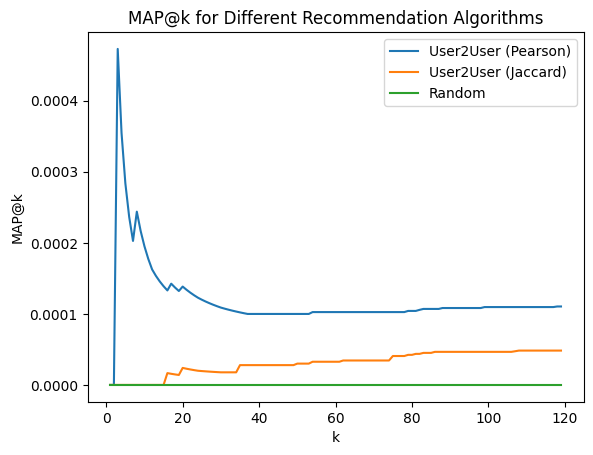

In [18]:
plt.plot(k_values, results_pearson, label = 'User2User (Pearson)')
plt.plot(k_values, results_jaccard, label = 'User2User (Jaccard)')
plt.plot(k_values, results_random, label = 'Random')
plt.xlabel('k')
plt.ylabel('MAP@k')
plt.title('MAP@k for Different Recommendation Algorithms')
plt.legend()
plt.show()

**Заключение:** функции (и Жаккара, и Пирсона) выходят на стабильный уровень при значении параметра k примерно от 35 до 40. В целом, по всем значениям k метрика Пирсона демонстрирует лучшие результаты, особенно заметное превосходство наблюдается при малых k — в первых 10 значениях она значительно опережает метрику Жаккара.

P.S.: У меня сначала вот так получилось (что-то у меня было такое с кодом, что шло 4 часа)

![Моя картинка](https://drive.google.com/uc?export=view&id=101pgNpUp8womkrlx9xJDMRcxlyS8p-7Y)

**Задание 6 (1.5 балла).** Как вы могли заметить, матрица оценок получается очень разреженной, но мы работаем с ней как с обычной, это не дело. Перепишите код так, чтобы все методы могли работать с разреженными матрицами и сравните скорость работы такого подхода с оригинальным.

In [19]:
from scipy import sparse

In [20]:
def pearson_sparse(ratings, user_vector):
    numerator = ratings @ user_vector.T
    denom_users = np.sqrt(ratings.sum(axis = 1))
    denom_user_vector = np.sqrt(user_vector.sum())
    pearson_sp = numerator / (denom_users * denom_user_vector)
    return pearson_sp

def jaccard_sparse(ratings, user_vector):
    numerator = ratings @ user_vector.T
    denom_users = ratings + sparse.csr_matrix(np.ones([ratings.shape[0], 1])) * user_vector
    denom_users = (denom_users > 0).sum(axis = 1)
    jaccard_sp = numerator / denom_users
    return jaccard_sp

In [21]:
class BaseModelSparse:
    def __init__(self, ratings: pd.DataFrame):
        self.ratings = ratings
        # Оптимизируем
        self.n_users = ratings['userId'].nunique()
        self.n_items = ratings['trackId'].nunique()
        self.R = np.zeros((self.n_users, self.n_items))
        self.R[self.ratings['userId'], self.ratings['trackId']] = 1.
        self.R = sparse.csr_matrix(self.R)

    def recommend(self, uid: int):
        raise NotImplementedError

    def remove_train_items(self, preds, k: int):
        new_preds = np.zeros((len(preds), k), dtype = int)
        for user_id, user_data in self.ratings.groupby('userId'):
            user_preds = preds[user_id]
            filt_preds = user_preds[~np.isin(user_preds, user_data['trackId'])][:k]
            new_preds[user_id, :len(filt_preds)] = filt_preds
        return new_preds

    def get_test_recommendations(self, k: int):
        test_preds = []
        for i in range(self.n_users):
            user_recommendations = self.recommend(i)
            test_preds.append(user_recommendations)
        test_preds = self.remove_train_items(test_preds, k)
        return test_preds

class User2UserSparse(BaseModelSparse):
    def __init__(self, ratings, similarity_func):
        super().__init__(ratings)

        assert similarity_func in [pearson_sparse, jaccard_sparse]

        self.similarity_func = similarity_func
        self.alpha = 0.02

    def similarity(self, user_vector: np.array):
        similarity_scores = self.similarity_func(self.R, user_vector).toarray()
        similarity_scores[similarity_scores <= self.alpha] = 0
        return similarity_scores

    def recommend(self, uid: int):
        user_vector = self.R[uid]
        user_similarity = sparse.csr_matrix(self.similarity(user_vector))
        summed_sim = np.sum(np.abs(user_similarity))
        rec_scores = (self.R.T @ user_similarity) / summed_sim
        rec_scores = rec_scores.T.toarray()[0]
        rec_score_sorted = np.argsort(rec_scores)[::-1]
        return rec_score_sorted

In [22]:
model = User2UserSparse(ratings, pearson_sparse)

Мы можем посмотреть глазами, насколько хорошо модель рекомендует треки. Для этого сравним уже прослушанные треки с рекомендованными и релевантными для случайного пользователя. Хорошо ли у вас получилось?

In [23]:
user_id = np.random.randint(0, model.n_users)

In [24]:
listened_tracks = train_ratings[train_ratings.userId == user_id].trackId[:15]

print('Already listened tracks:')

tracks_info.loc[listened_tracks][['name', 'artists']]

Already listened tracks:


,name,artists
494,Paganini Rhapsody (On Caprice 24),"['David Garrett', 'Niccolò Paganini']"
646,"Andante and Theme from Swan Lake, Act II, Op. 20","['Eugen Cicero', 'Pyotr Ilyich Tchaikovsky']"
647,"Valse in C sharp minor, Op. 64, No. 2","['Eugen Cicero', 'Фридерик Шопен']"
648,Hungarian Rhapsody No. 2,"['Eugen Cicero', 'Ferenc Liszt']"
649,Etude in G sharp minor (La Campanella),"['Eugen Cicero', 'Niccolò Paganini', 'Ferenc L..."
650,Solfeggio in C minor,"['Eugen Cicero', 'Карл Филипп Эммануил Бах']"
1379,All Fall Down,['OneRepublic']
1548,Dreamworld,['Robin Thicke']
1649,Cosmic Love,['Florence + The Machine']
2199,Secrets,['OneRepublic']


In [25]:
preds = model.get_test_recommendations(15)

print('Predicted tracks:')

tracks_info.loc[preds[user_id]][['name', 'artists']]

Predicted tracks:


,name,artists
33677,Caribbean Rave,['W&W']
18104,Castles In The Air,['Gravitonas']
2814,Numb,['Linkin Park']
50840,My Delorean,"['Timecop1983', 'Primo, the Alien']"
41901,The Hunter,['Adam jensen']
57031,I Love You,['Frank Sinatra']
62717,Dingga,['MAMAMOO']
8263,Shape Of My Heart,['Sting']
26714,Short Peace,['Ewan Dobson']
54223,Ретро,['Ундервуд']


In [26]:
test_tracks = test_ratings[test_ratings.userId == user_id].trackId[:15]

print('Test-time tracks:')

tracks_info.loc[test_tracks][['name', 'artists']]

Test-time tracks:


,name,artists
65596,Bonnie & Clyde,['YUQI']
65635,Advice,['TAEMIN']
65765,Seven Nation Army,"['Strange Fruits Music', 'DMNDS', 'KOYSINA']"
65864,November,"['Max Richter', 'BBC Philharmonic', 'Rumon Gam..."
65953,Say It Right,"['Sunlike Brothers', 'Micano']"
66287,"каждый, кто делал тебе больно","['забей, лерочка']"
66348,Wrecked,['Imagine Dragons']
66487,Fly Above,"['Mahmut Orhan', 'Sena Sener', 'Mert Oksuz']"


### Часть 2. Модель со скрытыми переменными

В этой части мы пощупаем метод рекомендаций со скрытыми переменными.
Идея: будем предсказывать оценки по формуле
$$
\hat{r}_{ui} = \langle p_u, q_u \rangle,
$$
$p_u \in \mathbb{R}^d$ и $q_i \in \mathbb{R}^d$ - латентные векторы пользователя $u$ и объекта $i$ соответственно.

Оптимизировать мы будем MSE между истинной оценкой пользователя и предсказанной с регуляризацией
$$
L = \sum_{(u, i) \in R} (\hat{r}_{ui} - r_{ui})^2 + \lambda \left(\sum_{u \in U} \|p_u\|^2 + \sum_{i \in I} \|q_i\|^2\right)
$$

**Задание 7 (1.5 балла).** На лекции рассматривались два подхода к оптимизации параметров. Можно это делать обычным стохастческим градинтным спуском, а можно по очереди обновлять матрицы $P, Q$, и тогда получится метод Alternating Least Squares (ALS). Вспомните формулы обновления и поясните их:

**SGD:**

Ответ: Для SGD для матричной факторизации считаем градиент

$$
    \frac{\partial L}{\partial p_u} = -2 \sum_{(u, i)\colon \exists r_{ui}} \left[ (r_{ui} - p_uq_i^T)q_i \right] + 2 \lambda \sum_{u \in U} p_u
$$
$$
    \frac{\partial L}{\partial q_i} = -2 \sum_{(u, i)\colon \exists r_{ui}} \left[ (r_{ui} - p_uq_i^T)p_u \right] + 2 \lambda \sum_{i \in I} q_i
$$

Будем обновлять параметры вот так:

$$
    p_{u_k} = p_{u_k} + \eta \left( (r_{u_k i_k} - p_{u_k} q_{i_k}^T) q_{i_k} - \lambda p_{u_k} \right)
$$
$$
    q_{i_k} = q_{i_k} + \eta \left( (r_{u_k i_k} - p_{u_k} q_{i_k}^T) p_{u_k} - \lambda q_{i_k} \right)
$$



**ALS:**

Ответ: (аналитически) мы поочерёдно фиксируем одну из матриц (либо Q, либо P) и решаем задачу минимизации квадратичной ошибки по другой.

$$
    p_u = \left( \sum_{i\colon \exists r_{ui}} q_i q_i^T \right)^{-1} \sum_{i\colon \exists r_{ui}} r_{ui}q_i
$$
$$
    q_i = \left( \sum_{u\colon \exists r_{ui}} p_u p_u^T \right)^{-1} \sum_{i\colon \exists r_{ui}} r_{ui}p_u
$$

Если оставлять нефиксированный одну строку $p_k$ или $q_k$, то оптимальное решение для данной строки будет выглядеть следующим образом:

$$
    p_k = \frac{q_k \left( R - \sum_{s \neq k} p_s q_s^T \right)^T}{q_k q_k^T}
$$
$$
    q_k = \frac{p_k \left( R - \sum_{s \neq k} p_s q_s^T \right)^T}{p_k p_k^T}
$$


**Задание 8 (2 балла).** А теперь реализуйте методы оптимизации параметров для обоих алгоритмов.

In [34]:
class HiddenVars(BaseModel):
    def __init__(self, ratings, lr=0.0003, lamb=0.01, dim=128, mode='sgd', calc=True):
        super().__init__(ratings)
        self.lr = lr
        self.lamb = lamb
        self.dim = dim
        assert mode in ['sgd', 'als']
        self.mode = mode
        self.P = np.random.normal(size=(self.n_users, dim))
        self.Q = np.random.normal(size=(self.n_items, dim))
        self.calc = calc
        self.predictions = []

    def fit(self, num_iters=5):
        indxs = np.where(self.R == 1)
        for epoch in tqdm(range(num_iters)):
            if self.mode == 'sgd':
                for used_index, item_index in zip(indxs[0], indxs[1]):
                  eshka = self.R[used_index][item_index] - self.P[used_index] @ self.Q[item_index].T
                  self.P[used_index] += self.lr * (eshka * self.Q[item_index] - self.lamb * self.P[used_index])
                  self.Q[item_index] += self.lr * (eshka * self.P[used_index] - self.lamb * self.Q[item_index])

            elif self.mode == 'als':
              user_index = np.random.choice(indxs[0])
              item_index = np.random.choice(indxs[1])
              indxs_i = indxs[1][indxs[0] == user_index]
              Q_cut = self.Q[indxs_i]
              s_Q = np.zeros((Q_cut.shape[1], Q_cut.shape[1]))
              for item_index in indxs_i:
                s_Q += np.array([self.Q[item_index]]).T @ np.array([self.Q[item_index]])
              self.P[user_index] = np.linalg.inv(s_Q + self.lamb * np.eye(Q_cut.shape[1])) @ np.sum(Q_cut, axis = 0)
              indxs_u = indxs[0][indxs[1] == item_index]
              P_cut = self.P[indxs_u]
              s_P = np.zeros((P_cut.shape[1], P_cut.shape[1]))
              for user_index in indxs_u:
                s_P += np.array([self.P[user_index]]).T @ np.array([self.P[user_index]])
              self.Q[item_index] = np.linalg.inv(s_P + self.lamb * np.eye(P_cut.shape[1])) @ np.sum(P_cut, axis = 0)

    def recommend(self, uid):
        pred_rating = self.P[uid] @ self.Q.T

        return np.argsort(pred_rating)[::-1]

**Задание 9 (1 балл).** Для обоих алгоритмов подберите оптимальные значения размерности скрытого пространства $d$ и размера предсказания $k$. Как изменяется качество предсказаний с числом итераций обучения? Постройте соответствующие графики, сравните со случайным подхом и User2User, сделайте выводы. Какой алгоритм вам кажется более подходящим для данной задачи и почему?

P.S. Хотя бы один из методов обучения должен приводить к лучшим результатам в сравнении с User2User подходом.

P.P.S. Методу LFM свойственно переобучаться, поэтому при подборе параметров полезно смотреть на значения ошибки и оптимизируемой метрики на тренировочном датасете. Вы также можете менять начальную инициализацию и прочие параметры, за исключением архитектуры, на ваш вкус.

In [28]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 10.5 MB/s eta 0:00:00


In [29]:
import optuna
import warnings
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)
optuna.logging.set_verbosity(optuna.logging.ERROR)

In [35]:
def sgdparams(trial):
    params = {
        'lr': trial.suggest_float('lr', 1e-4, 1e-2, step = (1e-2 - 1e-4) / 5),
        'lamb': trial.suggest_float('lamb', 0.01, 1, step = 0.03,),
        'dim': trial.suggest_int('dim', 64, 512, step = (512 - 64) / 5),
        'mode': 'sgd',
        'calc': False,
    }
    hidden_vars_sgd_model = HiddenVars(train_ratings, **params)
    hidden_vars_sgd_model.fit(8)
    recommendations = [hidden_vars_sgd_model.recommend(i) for i in test_users]
    return mapk(test_relevant, recommendations)

def alsparams(trial):
    params = {
        'lamb': trial.suggest_float('lamb', 0.01, 1, step = 0.03,),
        'dim': trial.suggest_int('dim', 64, 512, step = (512 - 64) / 5),
        'mode': 'als',
        'calc': False,
    }
    hidden_vars_als_model = HiddenVars(train_ratings, **params)
    hidden_vars_als_model.fit(8)
    recommendations = [hidden_vars_als_model.recommend(i) for i in test_users]
    return mapk(test_relevant, recommendations)

In [37]:
#Параметры для SGD
sgdparams_test = optuna.create_study(direction = 'maximize')
sgdparamstest.optimize(sgdparams, n_trials = 14)
sgdparams_test.best_params

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

{'lr': 0.00208, 'lamb': 0.94, 'dim': 242}

In [39]:
#Параметры для ALS
alsparams_test = optuna.create_study(direction = 'maximize')
alsparams_test.optimize(alsparams, n_trials = 14)
alsparams_test.best_params

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

{'lamb': 0.85, 'dim': 509}

In [40]:
hvsgd_model = HiddenVars(train_ratings, lr = 0.00208, lamb = 0.94, dim = 242, mode = 'sgd')
hvsgd_model.fit(15)
predictions_sgd = [hvsgd_model.recommend(i) for i in range(hvsgd_model.n_users)]
results_sgd = []
for k in k_values:
    results_sgd.append(mapk(test_relevant, predictions_sgd, k))

  0%|          | 0/15 [00:00<?, ?it/s]

In [41]:
hvals_model = HiddenVars(train_ratings, lamb = 0.85, dim = 509, mode = 'als')
hvals_model.fit(15)
predictions_als = [hvals_model.recommend(i) for i in range(hvals_model.n_users)]
results_als = []
for k in k_values:
    results_als.append(mapk(test_relevant, predictions_als, k))

  0%|          | 0/15 [00:00<?, ?it/s]

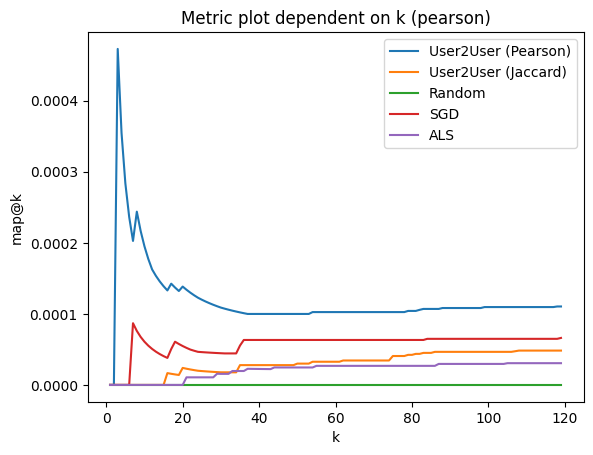

In [42]:
plt.plot(k_values, results_pearson, label = 'User2User (Pearson)')
plt.plot(k_values, results_jaccard, label = 'User2User (Jaccard)')
plt.plot(k_values, results_random, label = 'Random')
plt.plot(k_values, results_sgd, label = 'SGD')
plt.plot(k_values, results_als, label = 'ALS')
plt.xlabel('k')
plt.ylabel('map@k')

plt.title('Metric plot dependent on k (pearson)')
plt.legend()

plt.show()

**Получилось!!**

Если у вас получилось достаточно хорошее качество, то при оптимизации параметров марицы $Q$ похожим трекам стали соответствовать похожие векторы. Поэтому мы можем для любого трека найти наиболее близкие к нему в латентном пространстве и проверить степерь обученности модели вручную.

In [44]:
example_trackId = tracks_info[tracks_info.name == 'Выхода нет'].iloc[0].id

preds = hvals_model.Q @ hvals_model.Q[example_trackId]
preds = preds / np.sqrt((hvals_model.Q**2).sum(axis=1) + 1e-8)

track_idxs = preds.argsort()[::-1][:20]

In [46]:
similar_tracks = tracks_info.loc[track_idxs][['name', 'artists']]
similar_tracks['similarity'] = preds[track_idxs] / np.linalg.norm(hvals_model.Q[example_trackId])
similar_tracks

,name,artists,similarity
5512,Выхода нет,['Сплин'],1.000000
3435,Ordinary World,['Duran Duran'],0.195094
7057,The Doberman,['Kasabian'],0.188686
45471,From The Ritz To The Rubble,['Arctic Monkeys'],0.182049
17772,Метелица,['Валерия'],0.170283
11309,Снег над Ленинградом,['Микаэл Леонович Таривердиев'],0.168869
58246,100 Ways,['Jackson Wang'],0.165033
45183,Overdose,['Jackie-O'],0.163286
22174,Замок эдем,['МГК'],0.162471
31157,Dream,['OneRepublic'],0.162436
